# Detection des zones d'intérets :

In [1]:
import os
import numpy as np
import random
from PIL import Image
from skimage import color, feature, io
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.color import rgb2hsv
from sklearn import svm
from skimage import img_as_float, draw
from skimage.draw import rectangle

#### Fonctions d'extractions et d'imports du dataset

In [2]:
AVERAGE_SIZE_IMAGE = (127, 145)  # Thanks to the stats, we know that size of bbox will be (127, 145) -> Average size of labels 

def generate_empty_bbox(image_width, image_height):
    """ 
    Generate an empty box for images without label
    """
    # Generating random coords for the bbox
    x_min = random.randint(0, image_width - AVERAGE_SIZE_IMAGE[0])
    y_min = random.randint(0, image_height - AVERAGE_SIZE_IMAGE[1])
    
    # Compute complete coords of the bbox
    x_max = x_min + AVERAGE_SIZE_IMAGE[0]
    y_max = y_min + AVERAGE_SIZE_IMAGE[1]
    
    return (x_min, y_min, x_max, y_max)

def load_data(image_dir, label_dir):
    """ 
    Create a dict with all the usefull datas of the dataset
    datas = {
        "XXXX" (name of the file) : {
            "img" : image as an array,
            "labels" (data of the labels): {
                "X" index of the label (0,1,...,n) : {
                    "name" : name of the label,
                    "coord" : coord of the label like xmin, ymin, xmax, ymax,
                    "img" : crooped img of the label,
                }
            }
        }
    }
    """
    
    datas = {}

    for image_file in os.listdir(image_dir):
        # Computing name and files paths
        image_path = image_dir + '/' + image_file
        name = image_file.split('.')[0]
        label_path = label_dir + '/' + name + '.csv'
        
        # Import image as array
        image = np.array(Image.open(image_path))

        # Import labels as array 
        with open(label_path, 'r') as file:
            rows = file.readlines()

            label_data = {}
            if rows == ['\n']:  # Create a random empty label to balance model
                for i in range(2):
                    # Create random coords for empty label
                    xmin, ymin, xmax, ymax = generate_empty_bbox(image.shape[1], image.shape[0])
        
                    # Get the cropped image (as array) of the label
                    cropped_image = np.array(Image.fromarray(image[ymin:ymax, xmin:xmax]).resize(AVERAGE_SIZE_IMAGE))
                
                    label_data[i] = {
                            "name":"empty",
                            "coord": (xmin, ymin, xmax, ymax),
                            "img":cropped_image
                        }
            else:
                for i, row in enumerate(rows):  # One image can contain several labels
                    row = row.strip().split(",")

                    # Compute coords of the label
                    xmin, ymin, xmax, ymax = map(int, row[0:4])

                    # Get the label name
                    class_name = row[4]

                    # Get the cropped image (as array) of the label
                    cropped_image = np.array(Image.fromarray(image[ymin:ymax, xmin:xmax]).resize(AVERAGE_SIZE_IMAGE))
                    
                    # Adding to the json
                    label_data[i] = {
                        "name":class_name,
                        "coord": (xmin, ymin, xmax, ymax),
                        "img":cropped_image
                    }

        datas[name] = {
             "img" : image,
             "labels" : label_data,
        }
       
    return datas

# Dict to convert str class name to int
name_to_int = {
    "danger": 0,
    "interdiction": 1,
    "obligation": 2,
    "stop": 3,
    "ceder": 4,
    "frouge": 5,
    "forange": 6,
    "fvert": 7,
    "ff": 8,
    "empty": 9
}

def create_y(datas):
    # Creating Y array with all labels datas & classes
    Y = []

    for name, data in datas.items():
        for row in data["labels"].values():
            Y.append(name_to_int[row["name"]])

    Y = np.array(Y)

    return Y

def extract_detection_features(datas):
    # Creating X array with all HOG information of images
    X = []

    for name, data in datas.items():
        for row in data["labels"].values():
            # Convertir l'image en espace colorimétrique HSV
            hsv_image = rgb2hsv(row["img"])

            # Calculer l'histogramme de couleur pour chaque canal
            hue_hist = np.histogram(hsv_image[:,:,0], bins=10, range=(0, 1), density=True)[0]
            
            # Calculer les informations HOG 
            hog_values = np.array(hog(rgb2gray(row["img"]))).flatten()

            # Concaténer les histogrammes de couleur et les valeurs HOG
            concatenated_features = np.concatenate((hog_values, hue_hist))

            X.append(concatenated_features)

    return np.array(X)

#### Création des datasets 

In [3]:
# Create training dataset
datas_train = load_data("../../data/train/images", "../../data/train/labels")

# Create validation dataset
datas_val = load_data("../../data/val/images", "../../data/val/labels")

# Compute labels arrays
Y_train = create_y(datas=datas_train)
Y_val = create_y(datas=datas_val)

# Extract dectection informations
X_train = extract_detection_features(datas=datas_train)
X_val = extract_detection_features(datas=datas_val)


#### Création de la fenêtre glissante

In [4]:
# Fonction pour faire glisser une fenêtre sur l'image
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

# Dossier contenant les images de test
test_image_folder = '../../data/train/images'
output_folder = 'result_detection'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

step_size = 100  # Pas de la fenêtre

#### Mise en place de la détection

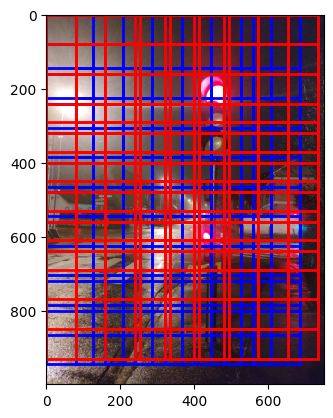

In [19]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

idx = 0
for filename in os.listdir(test_image_folder):
        if (idx<1):
                # Charger l'image de test
                test_image_path = os.path.join(test_image_folder, filename)
                test_image = io.imread(test_image_path)
                fig, ax = plt.subplots()
                ax.imshow(test_image)
                for window_size in [AVERAGE_SIZE_IMAGE, (AVERAGE_SIZE_IMAGE[0]*2, AVERAGE_SIZE_IMAGE[1]*2)]:          
                        # Faire glisser la fenêtre et détecter les feux rouges
                        for (x, y, imagebox) in sliding_window(test_image, step_size=80, window_size=window_size):
                                if imagebox.shape[0] != window_size[1] or imagebox.shape[1] != window_size[0]:
                                        continue

                                                
                                if window_size == (AVERAGE_SIZE_IMAGE[0]*2, AVERAGE_SIZE_IMAGE[1]*2):
                                        rect = Rectangle((x, y), window_size[0], window_size[1], edgecolor='r', facecolor='none', linewidth=2)
                                        ax.add_patch(rect)
                                else:
                                        rect = Rectangle((x, y), window_size[0], window_size[1], edgecolor='b', facecolor='none', linewidth=2)
                                        ax.add_patch(rect)
                idx+=1
        else:
                plt.show()
                break

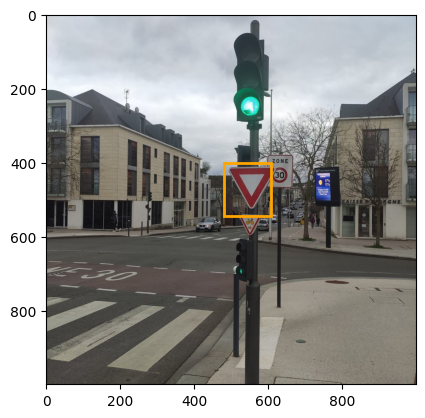

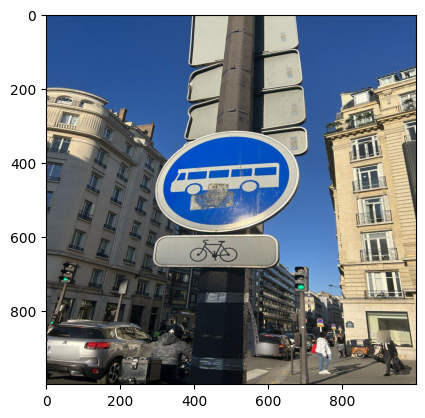

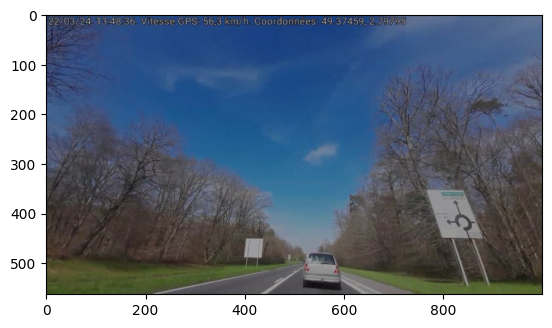

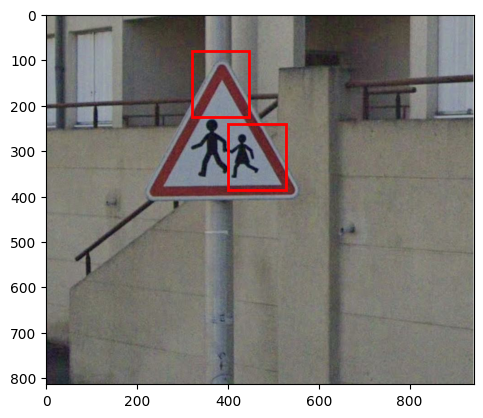

In [21]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

def output_to_color(output):
    # Mapping de l'output à des couleurs
    color_map = {
        0: 'red',
        1: 'green',
        2: 'blue',
        3: 'yellow',
        4: 'orange',
        5: 'purple',
        6: 'cyan',
        7: 'magenta',
        8: 'brown'
    }
    return color_map.get(output, 'black')


# Create classifier
clf = KNeighborsClassifier(n_neighbors=7) 
clf.fit(X_train, Y_train)


idx = 0
for filename in os.listdir(test_image_folder):
        if 5< idx < 10:
                # Charger l'image de test
                test_image_path = os.path.join(test_image_folder, filename)
                test_image = io.imread(test_image_path)
                fig, ax = plt.subplots()
                ax.imshow(test_image)      
                for window_size in [AVERAGE_SIZE_IMAGE]: 
                        # Faire glisser la fenêtre et détecter
                        for (x, y, imagebox) in sliding_window(test_image, step_size=80, window_size=window_size):
                                if imagebox.shape[0] != window_size[1] or imagebox.shape[1] != window_size[0]:
                                        continue
                                # Calculer les infos de HOG
                                image_hog = np.array(hog(rgb2gray(imagebox))).flatten()

                                # Calculer les infos de couleurs
                                hsv_image = rgb2hsv(imagebox)
                                hue_hist = np.histogram(hsv_image[:,:,0], bins=10, range=(0, 1), density=True)[0]                               
                                image_data = np.concatenate((image_hog, hue_hist))
                                output = clf.predict(image_data.reshape(1, -1))
                                if output != 9:
                                        rect = Rectangle((x, y), window_size[0], window_size[1], edgecolor=output_to_color(output[0]), facecolor='none', linewidth=2)
                                        ax.add_patch(rect)
                plt.show()
        idx+=1
